# Modelos Realizados 

In [44]:
import numpy as np, pandas as pd
import re
from pathlib import Path
import rasterio
from rasterio.transform import rowcol
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import rasterio

In [45]:
BASE = Path("descargas_sentinelhub")  # carpeta de los TIF
LAKES = ["atitlan", "amatitlan"]      # subcarpetas
BANDS_SUFFIX = ".bands.tiff"    # 9 bandas: B02,B03,B04,B05,B07,B08,B8A,B11,B12 (float32)
MASK_SUFFIX  = ".mask.tiff"           # 2 bandas: SCL, dataMask (uint8)
SCL_BAD = {3,8,9,10,11}

# Umbrales del script CyanoLakes
MNDWI_thr = 0.42
NDWI_thr  = 0.4
FILTER_UABS = True

### Función de Utilidad

In [46]:
def list_date_bases(lake_folder: Path):
    """
    Devuelve una lista de paths 'base' por fecha para un lago:
    BASE/lake/lake__YYYY-MM-DD  (sin sufijo)
    """
    bases = []
    for tif in lake_folder.glob(f"*__20??-??-??{BANDS_SUFFIX}"):
        date = re.search(r"__(\d{4}-\d{2}-\d{2})\.bands\.tiff$", tif.name).group(1)
        base = tif.with_suffix("").with_suffix("")
        bases.append((date, base))
    return sorted(bases, key=lambda x: x[0])

def load_stack(base_path: Path):
    """Lee el stack de 9 bandas (float32 reflectancia) y la máscara (SCL, dataMask)."""
    bands_path = base_path.with_suffix(BANDS_SUFFIX)
    mask_path  = base_path.with_suffix(MASK_SUFFIX)

    with rasterio.open(bands_path) as src:
        stack = src.read().astype("float32")
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = stack

    with rasterio.open(mask_path) as msrc:
        m = msrc.read()
        scl, dm = m[0].astype("int16"), m[1].astype("int16")

    return (b02,b03,b04,b05,b07,b08,b8a,b11,b12), scl, dm

### Índices calculados

In [47]:
def water_mask(b02,b03,b04,b08,b11,b12):
    ndvi  = (b08 - b04) / (b08 + b04 + 1e-6)                                     # (ndvi)
    mndwi = (b03 - b11) / (b03 + b11 + 1e-6)                                     # (mndwi)
    ndwi  = (b03 - b08) / (b03 + b08 + 1e-6)                                     # (ndwi)
    ndwi_leaves = (b08 - b11) / (b08 + b11 + 1e-6)                               # (ndwi_leaves)
    aweish  = b02 + 2.5*b03 - 1.5*(b08 + b11) - 0.25*b12                         # (aweish)
    aweinsh = 4*(b03 - b11) - (0.25*b08 + 2.75*b11)                              # (aweinsh)
    dbsi = ((b11 - b03) / (b11 + b03 + 1e-6)) - ndvi                             # (dbsi)

    ws = ((mndwi > MNDWI_thr) | (ndwi > NDWI_thr) | (aweinsh > 0.1879) |
          (aweish > 0.1112) | (ndvi < -0.2) | (ndwi_leaves > 1.0))

    if FILTER_UABS:
        ws = ws & ~((aweinsh <= -0.03) | (dbsi > 0))

    return ws

def fai(b04,b07,b8a):
    # FAI = B07 - (B04 + (B8A - B04) * (783-665)/(865-665))
    return b07 - (b04 + (b8a - b04) * ((783 - 665) / (865 - 665)))

def ndci(b04,b05):
    return (b05 - b04) / (b05 + b04 + 1e-6)

def chlorophyll_from_ndci(ndci_arr):
    # Polinomio del script
    return 826.57*ndci_arr**3 - 176.43*ndci_arr**2 + 19.0*ndci_arr + 4.071

def ndvi(b04,b08):
    return (b08 - b04) / (b08 + b04 + 1e-6)

def ndwi(b03,b08):
    return (b03 - b08) / (b03 + b08 + 1e-6)

### Modelo para determinar si un punto específico en el lago tiene cianobacteria o no 

In [48]:
def indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12):
    ndvi  = (b08-b04)/(b08+b04+1e-6)
    ndwi  = (b03-b08)/(b03+b08+1e-6)
    mndwi = (b03-b11)/(b03+b11+1e-6)
    ndci  = (b05-b04)/(b05+b04+1e-6)
    fai   = b07 - (b04 + (b8a - b04) * ((783 - 665)/(865 - 665)))

    chl   = 826.57*ndci**3 - 176.43*ndci**2 + 19.0*ndci + 4.071
    return ndvi, ndwi, mndwi, ndci, fai, chl

In [49]:
def sample_pixels_for_date(lake, date, max_samples=50000, seed=42):
    base = (BASE/lake).glob(f"{lake}__{date}*.bands.tiff")
    base = next(base, None)
    if base is None:
        return None
    bands_path = base
    mask_path  = Path(str(base).replace(".bands.tiff", ".mask.tiff"))

    with rasterio.open(bands_path) as src:
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = src.read().astype("float32")
        meta = src.meta.copy()
        transform, crs = src.transform, src.crs
        H, W = src.height, src.width

    with rasterio.open(mask_path) as msrc:
        scl, dm = msrc.read()
        scl = scl.astype("int16"); dm = dm.astype("int16")

    valid = (dm>0) & (~np.isin(scl, list(SCL_BAD)))
    water = water_mask(b02,b03,b04,b08,b11,b12) & valid

    ndvi, ndwi, mndwi, ndci, fai, chl = indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12)

    idx = np.flatnonzero(water.ravel())
    if idx.size == 0:
        return None
    rng = np.random.default_rng(seed)
    if idx.size > max_samples:
        idx = rng.choice(idx, size=max_samples, replace=False)

    # a DF “alto” por píxel
    def pick(a): return a.ravel()[idx]
    rows = idx // W
    cols = idx %  W

    df = pd.DataFrame({
        "lake": lake,
        "date": pd.to_datetime(date),
        "row": rows, "col": cols,
        "B02": pick(b02), "B03": pick(b03), "B04": pick(b04), "B05": pick(b05),
        "B07": pick(b07), "B08": pick(b08), "B8A": pick(b8a), "B11": pick(b11), "B12": pick(b12),
        "NDVI": pick(ndvi), "NDWI": pick(ndwi), "MNDWI": pick(mndwi),
        "NDCI": pick(ndci), "FAI": pick(fai), "CHL": pick(chl)
    })
    df.attrs["transform"] = transform
    df.attrs["crs"] = crs
    df.attrs["shape"] = (H, W)
    return df

In [50]:
def build_training_table(lakes, dates_per_lake=None, max_samples=50000):
    rows = []
    for lake in lakes:
        bases = list_date_bases(BASE/lake)
        keep = dates_per_lake or [d for d,_ in bases]
        for d,_ in bases:
            if str(d) not in set(keep): 
                continue
            print(f"sampling {lake} {d} ...")
            df = sample_pixels_for_date(lake, d, max_samples=max_samples)
            if df is not None:
                rows.append(df)
    return pd.concat(rows, ignore_index=True).reset_index(drop=True)

In [51]:
train_df = build_training_table(LAKES, max_samples=10000)

sampling atitlan 2025-02-07 ...
sampling atitlan 2025-02-10 ...
sampling atitlan 2025-02-25 ...
sampling atitlan 2025-02-27 ...
sampling atitlan 2025-03-02 ...
sampling atitlan 2025-03-04 ...
sampling atitlan 2025-03-07 ...
sampling atitlan 2025-03-09 ...
sampling atitlan 2025-03-12 ...
sampling atitlan 2025-03-14 ...
sampling atitlan 2025-03-19 ...
sampling atitlan 2025-03-22 ...
sampling atitlan 2025-03-24 ...
sampling atitlan 2025-03-26 ...
sampling atitlan 2025-04-03 ...
sampling atitlan 2025-04-11 ...
sampling atitlan 2025-04-13 ...
sampling atitlan 2025-04-15 ...
sampling atitlan 2025-04-16 ...
sampling atitlan 2025-04-18 ...
sampling atitlan 2025-04-28 ...
sampling atitlan 2025-05-03 ...
sampling atitlan 2025-05-13 ...
sampling atitlan 2025-05-28 ...
sampling atitlan 2025-07-10 ...
sampling atitlan 2025-07-17 ...
sampling atitlan 2025-07-20 ...
sampling atitlan 2025-07-24 ...
sampling atitlan 2025-08-01 ...
sampling amatitlan 2025-02-07 ...
sampling amatitlan 2025-02-10 ...
samp

In [52]:
p80 = train_df.groupby("lake")["CHL"].quantile(0.80).to_dict()
train_df["y"] = ((train_df["FAI"] > 0.08) | (train_df["CHL"] >= train_df["lake"].map(p80))).astype(int)
train_df["y"].value_counts(normalize=True)

y
0    0.799886
1    0.200114
Name: proportion, dtype: float64

In [53]:
all_dates = sorted(train_df["date"].unique())

test_dates = all_dates[-6:]
train_dates = all_dates[:-6]

print("Train:", train_dates)
print("Test:", test_dates)

Train: [Timestamp('2025-02-07 00:00:00'), Timestamp('2025-02-10 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-27 00:00:00'), Timestamp('2025-03-02 00:00:00'), Timestamp('2025-03-04 00:00:00'), Timestamp('2025-03-07 00:00:00'), Timestamp('2025-03-09 00:00:00'), Timestamp('2025-03-12 00:00:00'), Timestamp('2025-03-14 00:00:00'), Timestamp('2025-03-19 00:00:00'), Timestamp('2025-03-22 00:00:00'), Timestamp('2025-03-24 00:00:00'), Timestamp('2025-03-26 00:00:00'), Timestamp('2025-04-03 00:00:00'), Timestamp('2025-04-11 00:00:00'), Timestamp('2025-04-13 00:00:00'), Timestamp('2025-04-15 00:00:00'), Timestamp('2025-04-16 00:00:00'), Timestamp('2025-04-18 00:00:00'), Timestamp('2025-04-28 00:00:00'), Timestamp('2025-05-03 00:00:00'), Timestamp('2025-05-13 00:00:00')]
Test: [Timestamp('2025-05-28 00:00:00'), Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-20 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-08-01 00:00:00')]

In [54]:
FEATURES = ["B02","B03","B04","B05","B07","B08","B8A","B11","B12",
            "NDVI","NDWI","MNDWI","NDCI","FAI"]

train_set = train_df[train_df["date"].isin(train_dates)]
test_set  = train_df[train_df["date"].isin(test_dates)]

Xtr = train_set[FEATURES].astype("float32").values
ytr = train_set["y"].values

Xte = test_set[FEATURES].astype("float32").values
yte = test_set["y"].values

In [55]:
clf = RandomForestClassifier(
    n_estimators=400, max_depth=None, n_jobs=-1,
    class_weight="balanced", random_state=42
)
clf.fit(Xtr, ytr)
proba = clf.predict_proba(Xte)[:,1]

roc = roc_auc_score(yte, proba)
pr  = average_precision_score(yte, proba)
print(f"ROC-AUC={roc:.3f}  |  PR-AUC={pr:.3f}")

pred = (proba >= 0.5).astype(int)
print(classification_report(yte, pred, digits=3))

ROC-AUC=0.998  |  PR-AUC=0.993
              precision    recall  f1-score   support

           0      0.995     0.996     0.996     68009
           1      0.981     0.973     0.977     13322

    accuracy                          0.992     81331
   macro avg      0.988     0.985     0.986     81331
weighted avg      0.992     0.992     0.992     81331



In [56]:
def classify_point(lake, date, lon, lat, model=clf, threshold=0.5):
    # abre el .bands para esa fecha
    bands_path = next((BASE/lake).glob(f"{lake}__{date}*.bands.tiff"), None)
    if bands_path is None:
        raise FileNotFoundError("No encontré la imagen de esa fecha")
    with rasterio.open(bands_path) as src:
        row, col = rowcol(src.transform, lon, lat)
        b02,b03,b04,b05,b07,b08,b8a,b11,b12 = (src.read(i)[row, col] for i in range(1,10))
    ndvi, ndwi, mndwi, ndci, fai, chl = indices_and_chl(b02,b03,b04,b05,b07,b08,b8a,b11,b12)
    feat = np.array([[b02,b03,b04,b05,b07,b08,b8a,b11,b12, ndvi,ndwi,mndwi,ndci,fai]], dtype="float32")
    p = model.predict_proba(feat)[0,1]
    return {"proba": float(p), "label": int(p>=threshold), "lon": lon, "lat": lat, "chl_proxy": float(chl)}

In [60]:
print(test_dates)

[Timestamp('2025-05-28 00:00:00'), Timestamp('2025-07-10 00:00:00'), Timestamp('2025-07-17 00:00:00'), Timestamp('2025-07-20 00:00:00'), Timestamp('2025-07-24 00:00:00'), Timestamp('2025-08-01 00:00:00')]


In [72]:
def show_rgb_image(lake, date, bands=(4,3,2), gamma=1.0):
    tif_path = next((BASE/lake).glob(f"{lake}__{date}*.bands.tiff"), None)
    if tif_path is None:
        print("No se encontró la imagen")
        return

    with rasterio.open(tif_path) as src:
        rgb = np.stack([src.read(b) for b in bands])  
        rgb = np.transpose(rgb, (1, 2, 0))
        rgb = np.clip(rgb / 0.3, 0, 1)  
        rgb = rgb ** gamma
        plt.figure(figsize=(8,6))
        plt.imshow(rgb)
        plt.title(f"{lake.upper()} - {date}")
        plt.axis("off")
        plt.show()

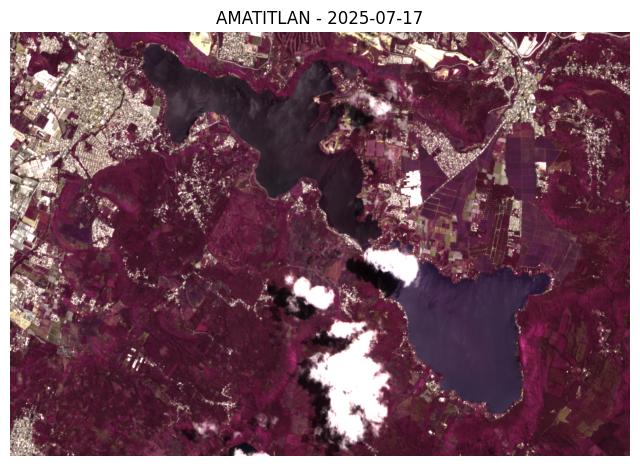

In [73]:
show_rgb_image("amatitlan", "2025-07-17")

In [67]:
classify_point("amatitlan", "2025-07-17", lon=-90.6024, lat=14.48)

{'proba': 0.075,
 'label': 0,
 'lon': -90.6024,
 'lat': 14.48,
 'chl_proxy': 5.022330284118652}

In [69]:
classify_point("amatitlan", "2025-07-17", lon=-90.5716, lat=14.4631)

{'proba': 0.0225,
 'label': 0,
 'lon': -90.5716,
 'lat': 14.4631,
 'chl_proxy': 8.138187408447266}